# Basic workflow for loading E,V data and training the filters

In [1]:
# Load generic python packages required

import pandas as pd
import pickle
import matplotlib.pylab as plt
import tensorflow as tf
import numpy as np
import networkx as nx
import seaborn as sns
import sys, os

# Load various RSMI-NE functions. In principle one can simply do "import rsmine" but then one needs to call 
# functions with syntax like rsmine.cg_optimisiers.xxxxxxxxx() etc.

sys.path.append("/home/cluster/mkochj/GitHub/RSMI-NE/rsmine/coarsegrainer")
import build_dataset as ds
import cg_optimisers as cg_opt
import plotter
from cg_utils import *
from analysis_utils import *


/home/cluster/mkochj/GitHub/RSMI-NE/rsmine/coarsegrainer/build_dataset.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [16]:
############# Load the definition of the graph and construct the reference graph

examples_dir = '/home/cluster/mkochj/GitHub/RSMI-NE/examples'

edges=np.loadtxt(examples_dir+'/quasiperiodic_data/edgedata.dat')
nodes=np.loadtxt(examples_dir+'/quasiperiodic_data/nodedata.dat',usecols=[0])
nodepos=np.loadtxt(examples_dir+'/quasiperiodic_data/nodedata.dat',usecols=[1,2])
order_8 = np.loadtxt(examples_dir+'/quasiperiodic_data/order_of_8vtx.dat')

G = construct_reference_graph(edges,nodes)

In [3]:
# Set the various parameters of the system required by the code 
# EV_params and data_params are generic data about samples of E,V


case_no= 18 # env, buffer, ll only come into play if case is set to "0"
V_index = 389 #389 is the centeral 8-vertex order 4 # 196 and 253 are 8-vertices of order 2 # 211 is 8-vertex of order 0
V_order = order_8[V_index][1]

samples = [10705,12121] #[12121]   Seed numbers for the MC sample files. Each seed is 50k samples.
sample_no = int("".join([str(i) for i in samples])) # concatenated sample string. An auxillary variable.

env_size = 8 # Not currently used by us
buffer_size = 2 # Not currently used by us
ll= 3 # Not currently used by us
disc=1


#We store these in a dictionary for experiment logging purposes only
EV_params = {
    'env_size' : env_size,
    'buffer_size': buffer_size,
    'block_size': ll, #assuming square block shape
    'sample_no': sample_no,
    'V_index': V_index,
    'V_order': V_order,
    'case_no':case_no
}

# These are needed by the generator
data_params = {
    'model': 'dimer_graph',
    'lattice_type': 'networkx',
    'L': 2048, # unused currently
    'N_samples': 1, # 1 is default. Set to actual value after generating or loading data.
    'dimension': 2,
}

In [15]:
######### Loading the (PRE-EXISTING) E,V data samples ##########

EV_dir = "/scratch/mkochj/sobisw/data/EandV"

Es_list=[]
Vs_list=[]

for sample in samples:
    Es_list.append(np.load(os.path.join(EV_dir,"Es_%i_vi%i_c%i.npy" % (sample,EV_params['V_index'],EV_params['case_no']))))
    Vs_list.append(np.load(os.path.join(EV_dir,"Vs_%i_vi%i_c%i.npy" % (sample,EV_params['V_index'],EV_params['case_no']))))
        
Es = np.reshape(Es_list,newshape=(len(Es_list)*Es_list[0].shape[0],Es_list[0].shape[1]))
Vs = np.reshape(Vs_list,newshape=(len(Vs_list)*Vs_list[0].shape[0],Vs_list[0].shape[1],1)) # REMEMBER about the additional axis for Vs !!!!!
print("shapes: ", Es.shape,Vs.shape)

data_params['N_samples'] = len(Vs) 
print('len(Vs): ',len(Vs))

shapes:  (100000, 8112) (100000, 872, 1)
len(Vs):  100000


In [6]:
# critic_params specify the MI estimator network -- not likely you need to touch that
# CG_params specify the coarse-grainer
# opt_params the settings of the training algorithm


run_no=0 # to distinguish indpendent repetition of the experiment (other parameters being equal)

hidden_dim = 2 # Number of "CG variables"
discrete_var = 0 # !!!!! --- !!!!! "1" is a "discrete" CG variable, sampled with Gumbel-Softmax, 0 is continous.
nonlinearCG_layers = [2,4,4,2] #[0] is a linear filter (i.e. a single LINEAR neuron), else a list of dense layers defining the nonlinear CG.

batch_size =  400 # typically we use 400 or 800
iterations =  10 # L2 regularization of activations, useful with unbounded activations like relu

relaxation_rate = 0.05e-4 # Gumbel-Softmax relaxation rate (from uniform to true categorical distribution)
learning_rate = 1.2e-4 # typically around 1e-4, but can be played with, seems to work in the range [0.2-2. e-4]


init_rule = None # Can be used to feed pre-trained filters.

hidden_activations = 'relu' # activations of the *in-between* dense-layers of nonlinear CG. The last one doesn't have any.
hidden_activations_L2_reg = 1e-5

##### Setting optimizer params ##########

CG_params = {
    'll' : ll,
    'size_V': Vs.shape[1],
    'init_temperature': 0.5, # Gumbel-Softmax initial temperature
    'min_temperature': 0.05, # Gumbel-Softmax min temperature
    'relaxation_rate': relaxation_rate, # Gumbel-Softmax relaxation rate
    'Nq': None, # Number of components of the d.o.f.s -- None means they will be set by default to a single component
    'conv_activation': tf.sigmoid, # If *not* using Gumbel-Softmax discretisation, this activation will be applied to the output of the coarse-grainer
    'hidden_dim': hidden_dim, # Number of "CG variables"
    'h_embed': discrete_var, #True is discrete, False is continous
    'nonlinearCG': nonlinearCG_layers, # [0] or None for standard linear CG coupling, a list of stacked dense layer sizes otherwise.
    'hidden_activations': hidden_activations, # activation function of the *in-between* dense-layers. The last one doesn't have any.
    'hidden_activations_L2_reg': hidden_activations_L2_reg, # L2 regularization of activations, useful with unbounded activations like relu
    'use_probs': False,
    'use_logits': True
}

critic_params = {
    'layers': 2, 
    'embed_dim': 8, 
    'hidden_dim': 32, 
    'activation': 'relu',
    'use_dropout': True,
    'dropout_rate': 0.4,
}

opt_params = {
    "batch_size": batch_size, 
    "iterations": iterations,
    "shuffle": len(Vs),
    "learning_rate": learning_rate 
}

run_params = {
    "run_no": run_no, # to distinguish indpendent repetition of the experiment (other parameters being equal)
    "use_GPU": True
}

all_params = {}
all_params.update(EV_params)
all_params.update(data_params)
all_params.update(CG_params)
all_params.update(critic_params)
all_params.update(opt_params)
all_params.update(run_params)
print(all_params)

{'env_size': 8, 'buffer_size': 2, 'block_size': 3, 'sample_no': 1070512121, 'V_index': 389, 'V_order': 4.0, 'case_no': 18, 'model': 'dimer_graph', 'lattice_type': 'networkx', 'L': 2048, 'N_samples': 100000, 'dimension': 2, 'll': 3, 'size_V': 872, 'init_temperature': 0.5, 'min_temperature': 0.05, 'relaxation_rate': 5e-06, 'Nq': None, 'conv_activation': <function sigmoid at 0x7f24ac287c10>, 'hidden_dim': 32, 'h_embed': 0, 'nonlinearCG': [2, 4, 4, 2], 'hidden_activations': 'relu', 'hidden_activations_L2_reg': 1e-05, 'use_probs': False, 'use_logits': True, 'layers': 2, 'embed_dim': 8, 'activation': 'relu', 'use_dropout': True, 'dropout_rate': 0.4, 'batch_size': 400, 'iterations': 10, 'shuffle': 100000, 'learning_rate': 0.00012, 'run_no': 0, 'use_GPU': True}


In [7]:
############## TRAIN (a single instance) ###############
data_params['N_samples'] = len(Vs)

estimates, _, filters, _ = cg_opt.train_RSMI_optimiser(CG_params, critic_params, opt_params, data_params,E=Es, V=Vs, use_GPU = run_params['use_GPU'],init_rule=init_rule)

[2, 4, 4, 2]
relu
Hidden dim:  2
Ver 3


  0%|          | 0/2500 [00:00<?, ?it/s]

Len dat:  2500
Training complete.


/home/cluster/mkochj/GitHub/RSMI-NE/rsmine/coarsegrainer/cg_optimisers.py:221: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(estimates), np.array(coarse_vars), np.array(filters), CG._Λ


# Crudely check/visualize the training:

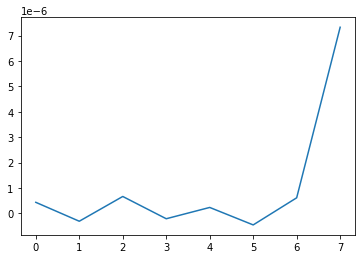

In [9]:
# Plot the mutual information (MI) as a function of training step:
plt.plot(estimates[2:])

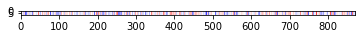

In [10]:
# plot the filters (flattened to a 1D array) with time dimension going down:
heat = np.array([ filters[i][0][:,0] for i in range(len(filters))])
plt.imshow(heat, cmap='bwr', interpolation='nearest')
plt.show()

# Use built-in functions to visualize the trained filters:

In [17]:
# For that visualization need to load the definitions of membranes, domains etc.
regions_data_dir = examples_dir + '/quasiperiodic_data/regions/'

mem_edges0_ids = eids_from_edges(edges,np.loadtxt(regions_data_dir + 'reg_mem_edgelist_svtx%i_sord%i_mem0.dat'%(EV_params['V_index'],EV_params['V_order']),dtype=int))
mem_edges1_ids = eids_from_edges(edges,np.loadtxt(regions_data_dir + 'reg_mem_edgelist_svtx%i_sord%i_mem1.dat'%(EV_params['V_index'],EV_params['V_order']),dtype=int))
mem_edges2_ids = eids_from_edges(edges,np.loadtxt(regions_data_dir + 'reg_mem_edgelist_svtx%i_sord%i_mem2.dat'%(EV_params['V_index'],EV_params['V_order']),dtype=int))
reg_edges0_ids = eids_from_edges(edges,np.loadtxt(regions_data_dir + 'reg_edgelist_svtx%i_sord%i_mem0.dat'%(EV_params['V_index'],EV_params['V_order']),dtype=int))
reg_edges1_ids = eids_from_edges(edges,np.loadtxt(regions_data_dir + 'reg_edgelist_svtx%i_sord%i_mem1.dat'%(EV_params['V_index'],EV_params['V_order']),dtype=int))
reg_edges2_ids = eids_from_edges(edges,np.loadtxt(regions_data_dir + '/reg_edgelist_svtx%i_sord%i_mem2.dat'%(EV_params['V_index'],EV_params['V_order']),dtype=int))

#GV_edges,GE_edges = construct_VE_edgelists(G, V_index, L_B=buffer_size, ll=ll, cap=ll+buffer_size+env_size)

ball5,_ = construct_VE_edgelists(G, V_index, L_B=1, ll=5, cap=8)
ball8,_ = construct_VE_edgelists(G, V_index, L_B=1, ll=8, cap=11)
ball12,_ = construct_VE_edgelists(G, V_index, L_B=1, ll=12, cap=15)
ball16,_ = construct_VE_edgelists(G, V_index, L_B=1, ll=16, cap=19)
ball32,_ = construct_VE_edgelists(G, V_index, L_B=1, ll=32, cap=35)
ball48,_ = construct_VE_edgelists(G, V_index, L_B=1, ll=48, cap=50)
ball24,_ = construct_VE_edgelists(G, V_index, L_B=1, ll=24, cap=26)

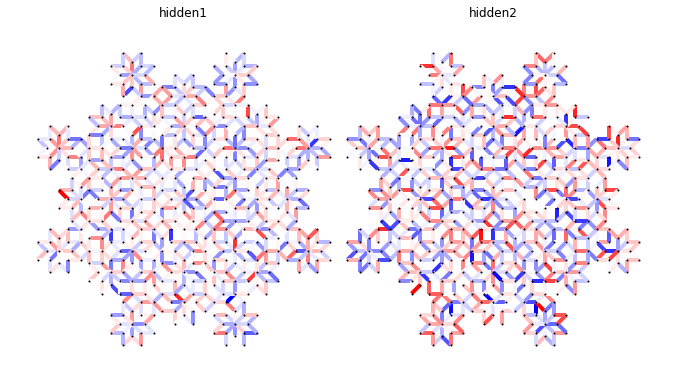

In [12]:
# The nice built-in visualization functions expect this "dictionary of cases" format of inputs.

cGV_edges = {}
cGE_edges = {}

auxGV_edges = sorted(set(reg_edges2_ids))
auxGE_edges = sorted(set(ball48) -set(ball24))#  #sorted(set(reg_edges2_ids)-(set(reg_edges0_ids) | set(mem_edges0_ids)))
cGV_edges[18] = auxGV_edges
cGE_edges[18] = auxGE_edges

scale_fac = int(np.ceil(np.cbrt(len(cGV_edges[18]))))
small_V_visualize(cGV_edges[18],filters[-1][0], edges=edges, nodes=nodes, nodepos=nodepos,n_rows=1, n_cols=2, figsize=(1.*scale_fac,.5*scale_fac),title="hidden", width=4)